# Monday, November 24th, 2025

## Recap: 
Last week, we continued discussing implementing Conway's [Game of Life](https://conwaylife.com/wiki/Conway%27s_Game_of_Life) in Python. First, let's recall some of the code that we developed. To start, we import NumPy, PyPlot, the `FuncAnimation` function, and we set PyPlot to run in an interactive mode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

We defined the `get_padded_cells` function (which was based on the analagous function from our Image Denoising project), which placed rows of non-living cells above and below and columns of non-living cells to the left and right of our `cells` array. This function returns this new `padded_cells` array.

In [2]:
def get_padded_cells(cells, pad=1):
    num_rows, num_cols = cells.shape
    padded_cells = np.zeros((num_rows + 2*pad, num_cols + 2*pad), dtype=int)
    padded_cells[pad:-pad, pad:-pad] = cells
    return padded_cells

Next, we wrote a function `count_live_neighbors` that takes in the `padded_cells` array along with row/column indices `i`/`j`, and counts the number of live neighbors that the `[i,j]`th cell has.

In [9]:
def count_live_neighbors(padded_cells, i, j):
    neighbors = padded_cells[i:i+3, j:j+3]
    live_neighbors = np.sum(neighbors) - neighbors[1,1]
    return live_neighbors

We also defined a function `update_cells` that takes in an array, `cells`, which stores a configuration of live/dead cells, and returns the next configuration after applying the rules of the Game of Life.

In [10]:
def update_cells_old(cells):
    num_rows, num_cols = cells.shape
    updated_cells = cells.copy()
    padded_cells = get_padded_cells(cells)
    for row in range(num_rows):
        for col in range(num_cols):
            live_neighbors = count_live_neighbors(padded_cells, row, col)
            # If a live cell has exactly two or three living neighbors, it stays alive
            if cells[row, col] == 1 and (live_neighbors == 2 or live_neighbors == 3):
                updated_cells[row, col] = 1
            # If a dead cell has exactly three living neighbors, it becomes alive
            elif cells[row, col] == 0 and live_neighbors == 3:
                updated_cells[row, col] = 1
            # All other cells are dead
            else:
                updated_cells[row, col] = 0

    return updated_cells

## Improving runtime

As discussed last week, it might be useful to think of ways to make our simulations run more quickly. This way, we can run more simulations to better analyze the dynamics. We can revisit the idea of shifting the `cells` array around to build the required collections of neighboring cells.

Recall that, for the Image Denoising project, we discussed the idea of constructing a stacked array of shape `(9, n, n)`, where each slice `[k, :, :]` gave a shifted version of the `cells` array (either up-left, up, up-right, left, etc.). In particular, looking at a slice `[:, i, j]` would give each of the entries of the `3` by `3` grid of cells centered at cell `[i,j]`.

Below is a snippet of code that was written in the [Week 10, Day 2 notebook](https://jllottes.github.io/_static/weekly_notebooks/week10_notebook_day2.html). 

<blockquote>
    
```
shifts = []

for i_shift in [-1,0,1]:
    for j_shift in [-1,0,1]:
        shift = padded_img[1 + i_shift:num_rows-1 + i_shift, 1 + j_shift:num_cols-1 + j_shift]
        shifts.append(shift)

median_filtered_img = np.median(shifts, axis=0)
```

</blockquote>

Let's make some minor adjustments to use this with the Game of Life. To make sure things are working correctly, let's revisit the example of the single column of three live cells. We wrote a function `starting_state` that creates such a cell configuration.

In [3]:
def starting_state(n):
    cells = np.zeros((n,n), dtype=int)
    cells[n//2-1:n//2+2, n//2] = 1

    return cells

Now, let's adapt the code from the Image Denoising project. We will want to omit the un-shifted `cells` array from our list of shifts, since we don't include the cell itself as one of its own neighbors.

In [4]:
cells = starting_state(10)
padded_cells = get_padded_cells(cells)

cells_shifts = []               # Initialize an empty list to contain each shifted version of the `cells` array

num_rows, num_cols = padded_cells.shape
for i_shift in [-1,0,1]:                    # For vertical shifts right, centered, and left
    for j_shift in [-1,0,1]:                # For horizontal shifts up, centered, and down
        if i_shift == 0 and j_shift == 0:   # If we are considering the unshifted `cells` array...
            continue                        # ...skip to the next shift
        # Take a slice of the padded array that is shifted left/right by i_shift and up/down by j_shift
        cells_shift = padded_cells[1 + i_shift:num_rows-1 + i_shift, 1 + j_shift:num_cols-1 + j_shift]
        cells_shifts.append(cells_shift)

cells_shifts = np.array(cells_shifts)   # Convert to an array for ease of slicing

In [5]:
cells_shifts.shape

(8, 10, 10)

With this setup, we can compute ALL live neighbor counts by summing through the first axis of the `cells_shifts` array. Let's do this and use `plt.imshow` to check that the results make sense.

In [6]:
live_neighbors_array = np.sum(cells_shifts,axis=0)

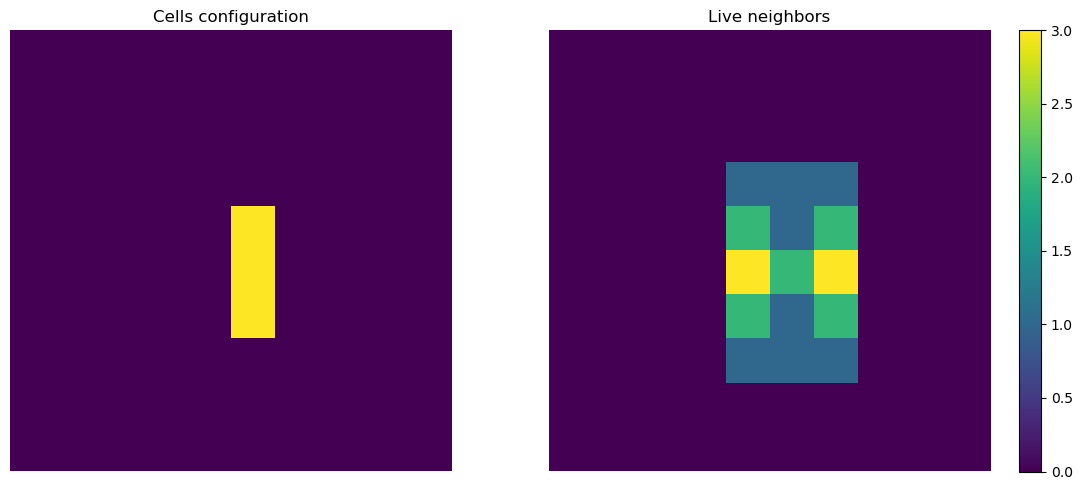

In [7]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(cells)
plt.axis('off')
plt.title('Cells configuration')

plt.subplot(1,2,2)
plt.imshow(live_neighbors_array)
plt.axis('off')
plt.title('Live neighbors')
plt.colorbar()

plt.tight_layout()

**Exercise:** Write a function `count_live_neighbors_array` that implements this strategy for counting the number of live neighbors for every cell.

In [8]:
def count_live_neighbors_array(cells):
    padded_cells = get_padded_cells(cells)
    
    cells_shifts = []               # Initialize an empty list to contain each shifted version of the `cells` array
    
    num_rows, num_cols = padded_cells.shape
    for i_shift in [-1,0,1]:                    # For vertical shifts right, centered, and left
        for j_shift in [-1,0,1]:                # For horizontal shifts up, centered, and down
            if i_shift == 0 and j_shift == 0:   # If we are considering the unshifted `cells` array...
                continue                        # ...skip to the next shift
            # Take a slice of the padded array that is shifted left/right by i_shift and up/down by j_shift
            cells_shift = padded_cells[1 + i_shift:num_rows-1 + i_shift, 1 + j_shift:num_cols-1 + j_shift]
            cells_shifts.append(cells_shift)
    
    cells_shifts = np.array(cells_shifts)   # Convert to an array for ease of slicing

    live_neighbors_array = np.sum(cells_shifts,axis=0)

    return live_neighbors_array

**Exercise:** Modify the `update_cells` function to make use of the `count_live_neighbors_array`.

In [11]:
def update_cells(cells):
    num_rows, num_cols = cells.shape
    updated_cells = cells.copy()

    live_neighbors_array = count_live_neighbors_array(cells)
    
    for row in range(num_rows):
        for col in range(num_cols):
            live_neighbors = live_neighbors_array[row, col]
            # If a live cell has exactly two or three living neighbors, it stays alive
            if cells[row, col] == 1 and (live_neighbors == 2 or live_neighbors == 3):
                updated_cells[row, col] = 1
            # If a dead cell has exactly three living neighbors, it becomes alive
            elif cells[row, col] == 0 and live_neighbors == 3:
                updated_cells[row, col] = 1
            # All other cells are dead
            else:
                updated_cells[row, col] = 0

    return updated_cells

In [16]:
cells = starting_state(10)
updated_cells = update_cells_old(cells)

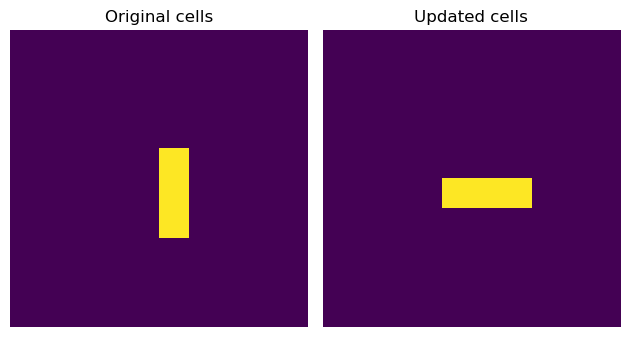

In [17]:
fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(cells)
plt.axis('off')
plt.title('Original cells')

plt.subplot(1,2,2)
plt.imshow(updated_cells)
plt.axis('off')
plt.title('Updated cells')

plt.tight_layout()

Now that we have our live neighbor counts stored in the form of an array, we can also rethink our `update_cells` function. In particular, we can replace the nested `for` loops (which go row-by-row, column-by-column through the grid of cells to update the state) with Boolean masks.

**Exercise:** Modify the `update_cells` function to use Boolean masking to update the state of the system.

*Note: We can multiply two Boolean arrays to work like "and" or add two Boolean arrays to work like "or".*

In [20]:
def update_cells(cells):
    live_neighbors_array = count_live_neighbors_array(cells)

    live_cells = (cells == 1)
    dead_cells = (cells == 0)
    two_live_neighbors = (live_neighbors_array == 2)
    three_live_neighbors = (live_neighbors_array == 3)
    
    stay_alive_mask = live_cells * (two_live_neighbors + three_live_neighbors)
    become_alive_mask = dead_cells * three_live_neighbors

    updated_cells = np.zeros(cells.shape)

    updated_cells[stay_alive_mask] = 1
    updated_cells[become_alive_mask] = 1

    return updated_cells

In [25]:
cells = starting_state(10)
updated_cells = update_cells(cells)

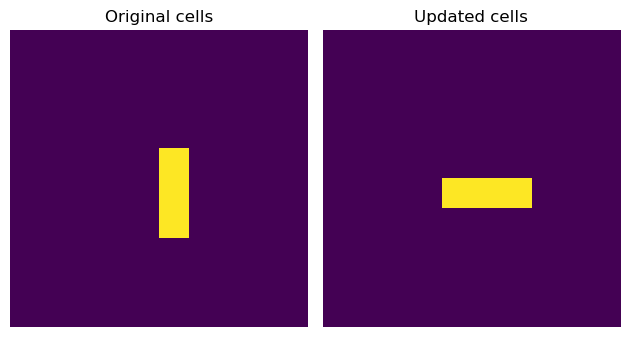

In [26]:
fig = plt.figure()

plt.subplot(1,2,1)
plt.imshow(cells)
plt.axis('off')
plt.title('Original cells')

plt.subplot(1,2,2)
plt.imshow(updated_cells)
plt.axis('off')
plt.title('Updated cells')

plt.tight_layout()

Let's compare the runtime of our old previous functions with the newly optimized versions.

In [28]:
import time

In [33]:
cells = starting_state(500)

t0 = time.time()
updated_cells = update_cells(cells)
t1 = time.time()

print('{} seconds using new `update_cells` function.'.format(t1-t0))

0.034871578216552734 seconds using new `update_cells` function.


In [34]:
t0 = time.time()
updated_cells = update_cells_old(cells)
t1 = time.time()

print('{} seconds using old `update_cells` function.'.format(t1-t0))

2.82029128074646 seconds using old `update_cells` function.


## Analyzing the Game of Life

Now that we can more simulate the Game of Life more quickly, let's continue with some of these questions we previously asked. First, let's recall the `random_starting_state` and `simulate_game_of_life` functions that we previously defined.

In [35]:
def random_starting_state(n=50, percent_live_cells=.1):
    cells = np.zeros((n,n), dtype=int)
    live_cell_mask = np.random.random((n,n)) < percent_live_cells
    cells[live_cell_mask] = 1
    return cells

In [36]:
def simulate_game_of_life(cells, T):
    n,m = cells.shape
    cells_history = np.zeros((n, m, T+1), dtype=int)
    cells_history[:,:,0] = cells
    
    for t in range(T):
        cells_history[:,:,t+1] = update_cells(cells_history[:,:,t])

    return cells_history

**Exercise:** For a given choice of parameters `n` (the square grid size), `percent_live_cells` (the portion of randomly selected cells that will be initially set to living), and `T` (number of time steps to simulate), simulate the Game of Life many times. Plot the number of live cells as a function of time along with the average the number of live cells between these numerous simulations in a single plot.

In [38]:
n = 100
percent_live_cells = .3
T = 100

number_of_simulations = 10

cells_history_list = []
for i in range(number_of_simulations):
    cells = random_starting_state(n, percent_live_cells)
    cells_history = simulate_game_of_life(cells, T)
    cells_history_list.append(cells_history)

Now that we've run several simulations, let's pick out the history of live cells for each.

In [39]:
number_of_live_cells_history_list = []
for cells_history in cells_history_list:
    number_of_live_cells_history = np.sum(cells_history, axis = (0,1))
    number_of_live_cells_history_list.append(number_of_live_cells_history)

For ease of slicing and accessing data, we can convert these lists to arrays.

In [40]:
cells_history_array = np.array(cells_history_list, dtype=int)
number_of_live_cells_history_array = np.array(number_of_live_cells_history_list)

print(cells_history_array.shape)
print(number_of_live_cells_history_array.shape)

(10, 100, 100, 101)
(10, 101)


Finally, we can plot each of these histories of live cells along with the average computed across each simulation.

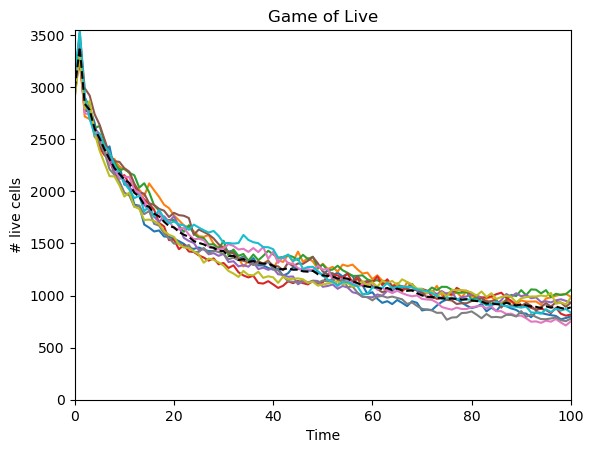

In [41]:
t_history = np.arange(T+1)
for number_of_live_cells_history in number_of_live_cells_history_array:
    plt.plot(t_history, number_of_live_cells_history)

number_of_live_cells_history_average = np.mean(number_of_live_cells_history_array, axis=0)
plt.plot(t_history, number_of_live_cells_history_average, 'k--')

plt.title('Game of Live')
plt.xlabel('Time')
plt.ylabel('# live cells')

plt.xlim(0,T)
plt.ylim((0, np.max(number_of_live_cells_history_array)))
plt.show()

**Exercise:** For a given choice of parameters `n` and `T`, simulate the Game of Life with several different choices of `percent_live_cells` used to generate the random initial configuration. Plot the number of live cells as a function of time for these numerous simulations in a single plot.

**Exercise:** For a given choice of parameters `percent_live_cells` and `T`, simulate the Game of Life with several different choices of square grid size `n`. Instead of plotting the number of live cells as a function of time, normalize this count by the size of the grid (e.g. by dividing by `n**2`). Plot this normalized count for each of the simulations in a single plot.

**Exercise:** For a given choice of parameter `T`, simulate the Game of Life with several combinations of choices for `n` and `percent_live_cells`. For each simulation, calculate the average number of live cells from the last `10` times steps (choose `T > 10` at least). Create an array to store this data and use `plt.imshow` to visualize this array.